# Load the dataset

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[25:-1] for item in glob('dogImages/train/*/')]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % str(len(train_files) + len(valid_files) + len(test_files)))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


# Visualize the first 12 training images

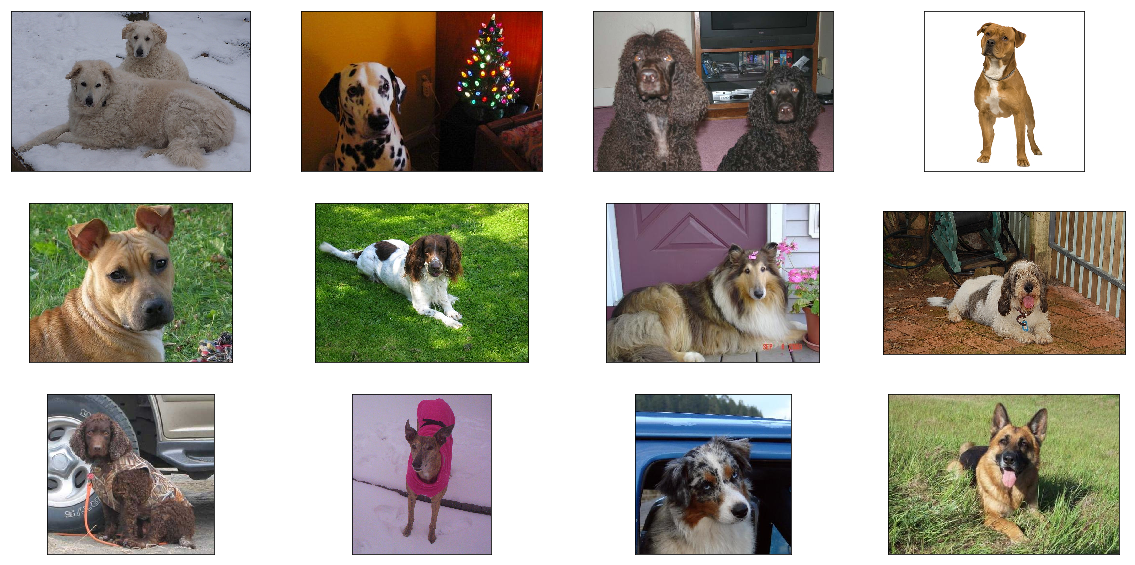

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path , ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize = (20 , 10))

for i in range(12):
    ax = fig.add_subplot(3 , 4 , i + 1 , xticks = [] , yticks = [])
    visualize_img(train_files[i] , ax)

# Obtain VGG-16 Bottleneck features

In [5]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_vgg16 = bottleneck_features['train']
test_vgg16 = bottleneck_features['test']
valid_vgg16 = bottleneck_features['valid']

# Define a model Architecture(Model 1) and compile it

In [9]:
from keras.models import Sequential
from keras.layers import Dense , Flatten

model = Sequential()
model.add(Flatten(input_shape=(7 , 7 , 512)))
model.add(Dense(133 , activation = 'softmax'))
model.compile(loss='categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 123)               3085947   
Total params: 3,085,947
Trainable params: 3,085,947
Non-trainable params: 0
_________________________________________________________________


# Define other model architecture(Model 2)

In [10]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape = (7 , 7 , 512)))
model.add(Dense(133 , activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


# Compile the Model 2 

In [11]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop' , metrics = ['accuracy'])

# Train the Model 2

In [12]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = 'dogvgg16.weights.best.hdf5' , verbose = 1 , save_best_only = True)

model.fit(train_vgg16 , train_targets , epochs = 20 , validation_data = (valid_vgg16 , valid_targets), callbacks = [checkpointer] , verbose = 1 , shuffle = True)

Instructions for updating:
Use tf.cast instead.
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 332us/step - loss: 12.1676 - acc: 0.1154 - val_loss: 10.2861 - val_acc: 0.2311

Epoch 00001: val_loss improved from inf to 10.28610, saving model to dogvgg16.weights.best.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 171us/step - loss: 9.3661 - acc: 0.2990 - val_loss: 9.1772 - val_acc: 0.3078

Epoch 00002: val_loss improved from 10.28610 to 9.17724, saving model to dogvgg16.weights.best.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 172us/step - loss: 8.5585 - acc: 0.3879 - val_loss: 8.9368 - val_acc: 0.3437

Epoch 00003: val_loss improved from 9.17724 to 8.93682, saving model to dogvgg16.weights.best.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 181us/step - loss: 8.2749 - acc: 0.4299 - val_loss: 8.6551 - val_acc: 0.3844

Epoch 00004: val_loss improved from 8.93682 to 8.65510, savi

# Load the Model with the best Validation Accuracy (Model 2)

In [13]:
model.load_weights('dogvgg16.weights.best.hdf5')

# Calculate Classification Accuracy on Test Set (Model 2)

In [14]:
vgg16_predictions = [np.argmax(model.predict(np.expand_dims(feature , axis = 0))) for feature in test_vgg16]

test_accuracy = 100*np.sum(np.array(vgg16_predictions) == np.argmax(test_targets , axis = 1)) / len(vgg16_predictions)

print('\nTest accuracy : %.4f%%' % test_accuracy)


Test accuracy : 50.1196%
